# **AI-Generated Text Detection Using Deep Learning Approach on Indonesian Text**
*Author: Kevin Wijaya*

## **Initial**

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.7 MB/s eta 0:00:00


In [ ]:
#Import Libraries

#utilities
import random, os, re, multiprocessing, nltk, gc
from tabulate import tabulate
from tqdm import tqdm
import time

#Processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

#Document/Word Vectorization
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess

#Modelling
import tensorflow as tf, torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from torch.optim import AdamW
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification as BertClassifier, get_linear_schedule_with_warmup

In [ ]:
#Setup seed for all python package
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

#other setups
indobert = 'indolem/indobert-base-uncased'
start_time = time.time()

In [ ]:
#Read data
df = pd.read_csv('data.csv', header=0)
df

,topic,text,label
0,artificial intelligence,Pj Gubernur DKI Jakarta Heru Budi Hartono mema...,human
1,artificial intelligence,Teknologi AI ini sudah dipasang di 20 persimpa...,human
2,artificial intelligence,"""Jadi ada 20 simpang yang sudah menerapkan pri...",human
3,artificial intelligence,"Penerapan AI, lanjut dia, juga dapat memperkua...",human
4,artificial intelligence,"""Jadi traffic light tersebut dapat 'melihat' k...",human
...,...,...,...
5003,kosmologi,Astronomi sendiri adalah ilmu yang memiliki as...,ai
5004,kosmologi,Mendorong rasa penasaran terhadap alam semesta...,ai
5005,kosmologi,"Memulai dengan mempelajari sejarah, karena dar...",ai
5006,kosmologi,"Menyelami Filsafat Fisika, menggali bagaimana ...",ai


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   topic   5008 non-null   object
 1   text    5008 non-null   object
 2   label   5008 non-null   object
dtypes: object(3)
memory usage: 117.5+ KB


In [ ]:
#Function for processing and etc
#Preprocessing each text
def text_preprocessing(text):
  #1.cleaning
  text = text.replace('-', ' ')
  text = re.sub(r'[\r\xa0\t]', '', text)
  text = re.sub(r"http\S+|www\S+", '', text)
  text = re.sub(r'\b\w*\.com\w*\b', '', text)
  text = re.sub(r'\[.*?\]|\(.*?\}|\{.*?\}', '', text)
  text = re.sub(r'\b(\w+)/(\w+)\b', r'\1 atau \2', text)
  text = re.sub(r'@[A-Za-z0-9]+|#[A-Za-z0-9]+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\s+', ' ', text)
  text = text.replace('\n', ' ')
  text = text.strip(' ')
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  #2.case folding
  text = text.lower()
  return text

#Preprocessing each docs
def data_preprocessing(data):
  data['text'] = data['text'].apply(lambda _: text_preprocessing(str(_)))
  return data

#Construct tagged data
def construct_tagged_document(X, y):
  tagged_data = [TaggedDocument(words=simple_preprocess(d), tags=[y[i], X.index[i]]) for i, d in enumerate(X)]
  return tagged_data

#Get vector data from model d2v
def d2v_vector(d2v, data_tagged):
  #unpacking tags and infer a vector
  labels, features = zip(*[(doc.tags[0], d2v.infer_vector(doc.words, epochs=20)) for doc in data_tagged])
  features = np.array(features)
  return features, labels

#reshape features & labels for neural network
def transform_data(features, labels):
  features = np.reshape(features, (features.shape[0], features.shape[1], 1))
  labels = np.array(labels).reshape((-1,1))
  return features, labels

#encode data with Bert Tokenizer
def encoded_data(tokenizer, data):
  return tokenizer.batch_encode_plus(
    data,
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    return_tensors='pt'
  )

def clean_memory():
  torch.cuda.empty_cache()
  gc.collect()

## **Wrangling Data**

In [ ]:
#preprocessing
data = df.copy()
data = data_preprocessing(data)
print(f'shape: {data.shape}')
data

shape: (5008, 3)


,topic,text,label
0,artificial intelligence,pj gubernur dki jakarta heru budi hartono mema...,human
1,artificial intelligence,teknologi ai ini sudah dipasang di persimpang...,human
2,artificial intelligence,jadi ada simpang yang sudah menerapkan prinsi...,human
3,artificial intelligence,penerapan ai lanjut dia juga dapat memperkuat ...,human
4,artificial intelligence,jadi traffic light tersebut dapat melihat kaki...,human
...,...,...,...
5003,kosmologi,astronomi sendiri adalah ilmu yang memiliki as...,ai
5004,kosmologi,mendorong rasa penasaran terhadap alam semesta...,ai
5005,kosmologi,memulai dengan mempelajari sejarah karena dari...,ai
5006,kosmologi,menyelami filsafat fisika menggali bagaimana p...,ai


In [ ]:
#handling empty string
print(f'shape (before): {data.shape}')
print(data[data['text'].str.len() == 0], '\n')
data = data[data['text'].str.len() > 0]
data.reset_index(drop=True, inplace=True)
print(f'shape (after): {data.shape}')

shape (before): (5008, 3)
Empty DataFrame
Columns: [topic, text, label]
Index: [] 

shape (after): (5008, 3)


In [ ]:
#Analyzing descriptive statistics of length Document
list_length = pd.DataFrame([len(sent) for sent in data['text']], columns=['value'])
descs = list_length.describe(); descs

,value
count,5008.000000
mean,257.907149
std,117.590307
min,23.000000
25%,183.000000
50%,234.000000
75%,301.000000
max,1241.000000


In [ ]:
#display frequency word
all_text = ' '.join(data['text'])
tokens = all_text.split()
freq_dist = nltk.FreqDist(tokens)
freq_df = pd.DataFrame(list(freq_dist.items()), columns=['word', 'frequency'])
freq_df.sort_values(ascending=False, by='frequency', inplace=True)
freq_df.reset_index(drop=True, inplace=True)
freq_df

,word,frequency
0,yang,7071
1,dan,4527
2,di,3389
3,untuk,2344
4,ini,2318
...,...,...
12392,komputernya,1
12393,delam,1
12394,bedakan,1
12395,kelayakan,1


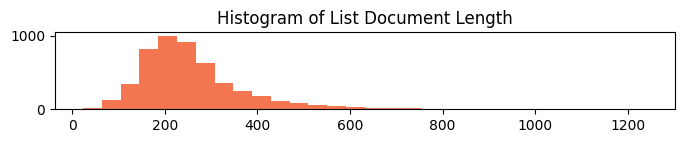

In [ ]:
plt.figure(figsize=(8, 1))
plt.hist(list_length, bins=30, color=sns.color_palette('rocket')[4])
plt.title("Histogram of List Document Length")
plt.show()

In [ ]:
data

,topic,text,label
0,artificial intelligence,pj gubernur dki jakarta heru budi hartono mema...,human
1,artificial intelligence,teknologi ai ini sudah dipasang di persimpang...,human
2,artificial intelligence,jadi ada simpang yang sudah menerapkan prinsi...,human
3,artificial intelligence,penerapan ai lanjut dia juga dapat memperkuat ...,human
4,artificial intelligence,jadi traffic light tersebut dapat melihat kaki...,human
...,...,...,...
5003,kosmologi,astronomi sendiri adalah ilmu yang memiliki as...,ai
5004,kosmologi,mendorong rasa penasaran terhadap alam semesta...,ai
5005,kosmologi,memulai dengan mempelajari sejarah karena dari...,ai
5006,kosmologi,menyelami filsafat fisika menggali bagaimana p...,ai


In [ ]:
#split data into Features and Labels
data = data.sample(frac=1, random_state=42)
X, y = data['text'], data['label'].map({'ai':1, 'human':0}).values

In [ ]:
#split into two set data (train & val)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=seed)
print(f'X_train shape:  {X_train.shape}')
print(f'y_train shape:  {y_train.shape}')
print(f'X_val shape:    {X_val.shape}')
print(f'y_val shape:    {y_val.shape}')

X_train shape:  (4006,)
y_train shape:  (4006,)
X_val shape:    (1002,)
y_val shape:    (1002,)


## **Vectorization**

### **Doc2Vec**

In [ ]:
#Construct Tagged Doccument
train_tagged = construct_tagged_document(X_train, y_train)
val_tagged = construct_tagged_document(X_val, y_val)
data_tagged = train_tagged + val_tagged
pd.DataFrame(data_tagged).head()

,words,tags
0,"[kenapa, dibuat, komputer, kuantum, karena, ko...","[0, 1579]"
1,"[pada, bulan, februari, sothebys, menjual, ber...","[1, 2622]"
2,"[universitas, udayana, di, bali, karena, saya,...","[1, 4932]"
3,"[misi, prodi, ilmu, teknik, uny, adalah, untuk...","[1, 3155]"
4,"[pada, senin, atau, andi, pangerang, hasanuddi...","[1, 3464]"


In [ ]:
#Build DOc2Vec Model
INPUT_DIM = 1000
EPOCHS = 20
MIN_COUNT = 0
RETRAIN = [True, False][  1 ]
cores = multiprocessing.cpu_count()

d2v=None
filename='Doc2Vec.d2v'

if os.path.isfile(filename) and RETRAIN == False:
    print('Read Model')
    d2v = Doc2Vec.load(filename)
else:
    print('Train Model...')
    d2v = Doc2Vec(dm=1, vector_size=INPUT_DIM,
                  negative=1, hs=0,
                  min_count=MIN_COUNT, workers=cores)
    d2v.build_vocab(data_tagged)
    d2v.train(data_tagged, total_examples=d2v.corpus_count, epochs=EPOCHS)
    d2v.save(filename)

vocab = len(d2v.dv)
print(f'Vocab: {vocab}')

Train Model...
Vocab: 5008


In [ ]:
#transform data into vector + reshaped data for tensorflow
X_train_vector, y_train_tag = d2v_vector(d2v, train_tagged)
X_train_reshaped, y_train_reshaped = transform_data(X_train_vector, y_train_tag)

X_val_vector, y_val_tag = d2v_vector(d2v, val_tagged)
X_val_reshaped, y_val_reshaped = transform_data(X_val_vector, y_val_tag)

print(f'X_train_reshaped shape : {X_train_reshaped.shape}')
print(f'y_train_reshaped shape : {y_train_reshaped.shape}')
print(f'X_val_reshaped shape : {X_val_reshaped.shape}')
print(f'y_val_reshaped shape : {y_val_reshaped.shape}')

X_train_reshaped shape : (4006, 1000, 1)
y_train_reshaped shape : (4006, 1)
X_val_reshaped shape : (1002, 1000, 1)
y_val_reshaped shape : (1002, 1)


### **BERT Tokenizer**

In [ ]:
#init model BertTokenizer using IndoBERT
tokenizer = BertTokenizer.from_pretrained(indobert, do_lower_case=True)

In [ ]:
#Encode the data
X_train_encoded = encoded_data(tokenizer, X_train)
X_val_encoded = encoded_data(tokenizer, X_val)

#seperated input_id, attention_mask and create label as tensor
X_train_ids = X_train_encoded['input_ids']
X_train_mask = X_train_encoded['attention_mask']
y_train_tensor = torch.tensor(y_train)

X_val_ids = X_val_encoded['input_ids']
X_val_mask = X_val_encoded['attention_mask']
y_val_tensor = torch.tensor(y_val)

print(f'X_train_ids shape:    {X_train_ids.shape}')
print(f'X_train_mask shape:   {X_train_mask.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')
print(f'X_val_ids shape:      {X_val_ids.shape}')
print(f'X_val_mask shape:     {X_val_mask.shape}')
print(f'y_val_tensor shape:   {y_val_tensor.shape}')

X_train_ids shape:    torch.Size([4006, 214])
X_train_mask shape:   torch.Size([4006, 214])
y_train_tensor shape: torch.Size([4006])
X_val_ids shape:      torch.Size([1002, 157])
X_val_mask shape:     torch.Size([1002, 157])
y_val_tensor shape:   torch.Size([1002])


In [ ]:
#Create tensor dataset
dataset_train = TensorDataset(X_train_ids, X_train_mask, y_train_tensor)
dataset_val = TensorDataset(X_val_ids, X_val_mask, y_val_tensor)

print(len(dataset_train))
print(len(dataset_val))

4006
1002


## **Modelling**

In [ ]:
#check GPU
print('Use GPU') if tf.test.is_built_with_cuda() and tf.config.list_physical_devices('GPU') else print('Use CPU')

Use GPU


In [ ]:
#init params
experiments = []
unit = 50
d_rate = 0.1
a_rate = 1e-4
deep_epochs = 30
deep_size = 15
bert_epochs = 10
bert_size = 15
clean_memory()

### **LSTM**

In [ ]:
#LSTM
lstm = Sequential(name='LSTM')
lstm.add(LSTM(unit, return_sequences=True))
lstm.add(Dropout(d_rate))
lstm.add(LSTM(unit, return_sequences=True))
lstm.add(Dropout(d_rate))
lstm.add(LSTM(unit, return_sequences=True))
lstm.add(Dropout(d_rate))
lstm.add(LSTM(unit))
lstm.add(Dropout(d_rate))
lstm.add(Dense(1, activation='sigmoid'))
lstm.build(input_shape=X_train_reshaped.shape)
lstm.compile(optimizer=Adam(learning_rate=a_rate), loss='binary_crossentropy', metrics=['accuracy'])
lstm.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (4006, 1000, 50)          10400     
                                                                 
 dropout (Dropout)           (4006, 1000, 50)          0         
                                                                 
 lstm_1 (LSTM)               (4006, 1000, 50)          20200     
                                                                 
 dropout_1 (Dropout)         (4006, 1000, 50)          0         
                                                                 
 lstm_2 (LSTM)               (4006, 1000, 50)          20200     
                                                                 
 dropout_2 (Dropout)         (4006, 1000, 50)          0         
                                                                 
 lstm_3 (LSTM)               (4006, 50)                20200  

In [ ]:
#training
checkpoint = ModelCheckpoint('LSTM.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
experiments.append(lstm.fit(X_train_reshaped, y_train_reshaped, validation_data=(X_val_reshaped, y_val_reshaped), epochs=deep_epochs, batch_size=deep_size, verbose=1, callbacks=[checkpoint]))
best_lstm = tf.keras.saving.load_model("LSTM.h5")

Epoch 1/30
268/268 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4970
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to LSTM.h5
268/268 [==============================] - 42s 112ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/30
268/268 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.5607
Epoch 2: val_accuracy improved from 0.50000 to 0.57984, saving model to LSTM.h5
268/268 [==============================] - 32s 121ms/step - loss: 0.6810 - accuracy: 0.5607 - val_loss: 0.6676 - val_accuracy: 0.5798
Epoch 3/30
268/268 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.6168
Epoch 3: val_accuracy improved from 0.57984 to 0.63473, saving model to LSTM.h5
268/268 [==============================] - 30s 114ms/step - loss: 0.6486 - accuracy: 0.6168 - val_loss: 0.6397 - val_accuracy: 0.6347
Epoch 4/30
268/268 [==============================] - ETA: 0s - loss: 0.5

In [ ]:
#evaluate
y_lstm_pred = best_lstm.predict(X_val_reshaped)
y_lstm_pred = np.round(y_lstm_pred).flatten()
print(classification_report(y_lstm_pred, y_val_reshaped))

32/32 [==============================] - 3s 46ms/step
              precision    recall  f1-score   support

         0.0       0.72      0.77      0.75       470
         1.0       0.78      0.74      0.76       532

    accuracy                           0.75      1002
   macro avg       0.75      0.75      0.75      1002
weighted avg       0.76      0.75      0.75      1002



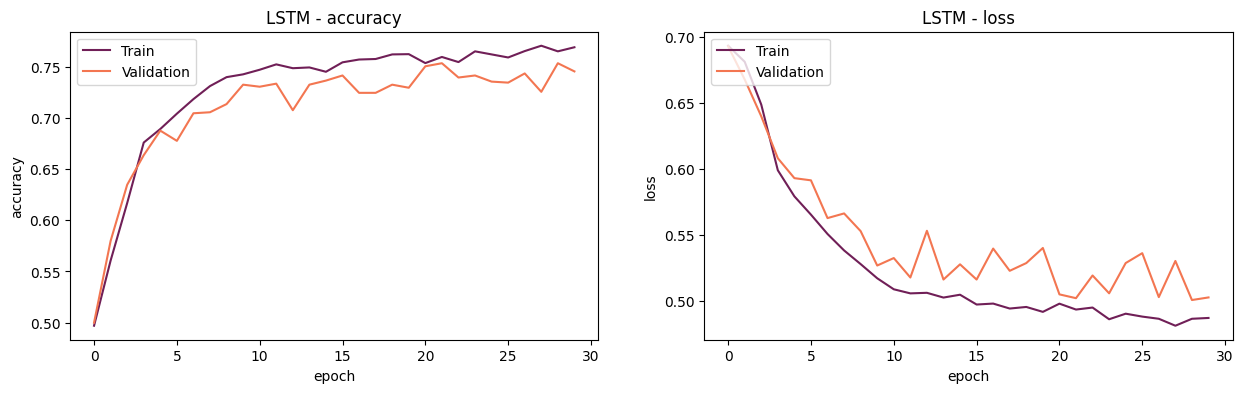

In [ ]:
#plot accuracy and loss
plt.figure(figsize=(15,4))
metrics_plot = ['accuracy', 'loss']
for i,metric in enumerate(metrics_plot):
  plt.subplot(1, 2, i+1)
  experiment = experiments[0]
  plt.plot(experiment.history[metric], color=sns.color_palette('rocket')[1])
  plt.plot(experiment.history[f'val_{metric}'], color=sns.color_palette('rocket')[4])
  plt.title(f'LSTM - {metric}')
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **GRU**

In [ ]:
#GRU
gru = Sequential(name='GRU')
gru.add(GRU(unit, return_sequences=True))
gru.add(Dropout(d_rate))
gru.add(GRU(unit, return_sequences=True))
gru.add(Dropout(d_rate))
gru.add(GRU(unit, return_sequences=True))
gru.add(Dropout(d_rate))
gru.add(GRU(unit))
gru.add(Dropout(d_rate))
gru.add(Dense(1, activation='sigmoid'))
gru.build(input_shape=X_train_reshaped.shape)
gru.compile(optimizer=Adam(learning_rate=a_rate), loss='binary_crossentropy', metrics=['accuracy'])
gru.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (4006, 1000, 50)          7950      
                                                                 
 dropout_4 (Dropout)         (4006, 1000, 50)          0         
                                                                 
 gru_1 (GRU)                 (4006, 1000, 50)          15300     
                                                                 
 dropout_5 (Dropout)         (4006, 1000, 50)          0         
                                                                 
 gru_2 (GRU)                 (4006, 1000, 50)          15300     
                                                                 
 dropout_6 (Dropout)         (4006, 1000, 50)          0         
                                                                 
 gru_3 (GRU)                 (4006, 50)                15300   

In [ ]:
#training
checkpoint = ModelCheckpoint('GRU.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
experiments.append(gru.fit(X_train_reshaped, y_train_reshaped, validation_data=(X_val_reshaped, y_val_reshaped), epochs=deep_epochs, batch_size=deep_size, verbose=1, callbacks=[checkpoint]))
best_gru = tf.keras.saving.load_model("GRU.h5")

Epoch 1/30
268/268 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4945
Epoch 1: val_accuracy improved from -inf to 0.50599, saving model to GRU.h5
268/268 [==============================] - 49s 133ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6927 - val_accuracy: 0.5060
Epoch 2/30
268/268 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5190
Epoch 2: val_accuracy improved from 0.50599 to 0.55788, saving model to GRU.h5
268/268 [==============================] - 28s 105ms/step - loss: 0.6927 - accuracy: 0.5190 - val_loss: 0.6918 - val_accuracy: 0.5579
Epoch 3/30
268/268 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.5330
Epoch 3: val_accuracy did not improve from 0.55788
268/268 [==============================] - 28s 105ms/step - loss: 0.6908 - accuracy: 0.5330 - val_loss: 0.6877 - val_accuracy: 0.5569
Epoch 4/30
268/268 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.5564
Epoch 4:

In [ ]:
#evaluate
y_gru_pred = best_gru.predict(X_val_reshaped)
y_gru_pred = np.round(y_gru_pred).flatten()
print(classification_report(y_gru_pred, y_val_reshaped))

32/32 [==============================] - 2s 44ms/step
              precision    recall  f1-score   support

         0.0       0.62      0.77      0.68       405
         1.0       0.81      0.68      0.74       597

    accuracy                           0.71      1002
   macro avg       0.71      0.72      0.71      1002
weighted avg       0.73      0.71      0.72      1002



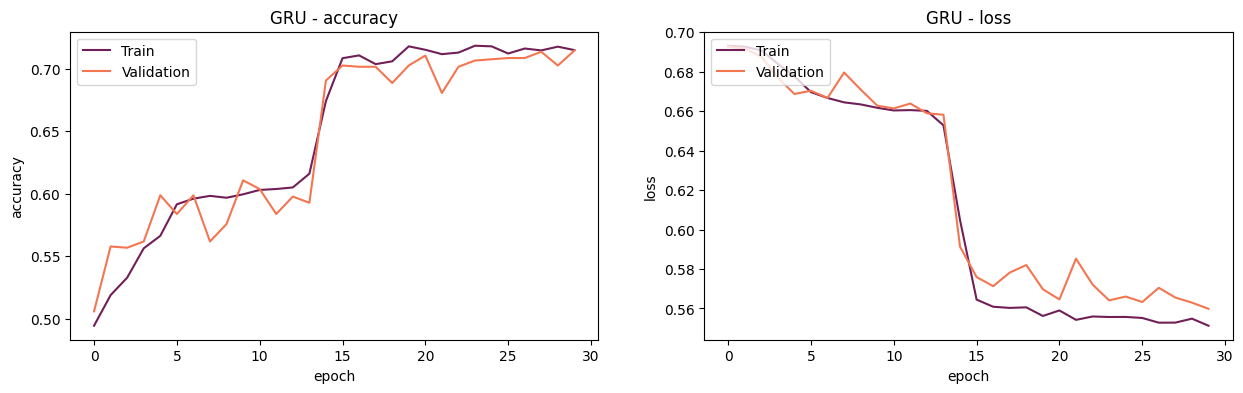

In [ ]:
#plot accuracy and loss
plt.figure(figsize=(15,4))
metrics_plot = ['accuracy', 'loss']
for i,metric in enumerate(metrics_plot):
  plt.subplot(1, 2, i+1)
  experiment = experiments[1]
  plt.plot(experiment.history[metric], color=sns.color_palette('rocket')[1])
  plt.plot(experiment.history[f'val_{metric}'], color=sns.color_palette('rocket')[4])
  plt.title(f'GRU - {metric}')
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **BI-LSTM**

In [ ]:
#BI-LSTM
bilstm = Sequential(name='BI_LSTM')
bilstm.add(Bidirectional(LSTM(unit, return_sequences=True)))
bilstm.add(Dropout(d_rate))
bilstm.add(Bidirectional(LSTM(unit, return_sequences=True)))
bilstm.add(Dropout(d_rate))
bilstm.add(Bidirectional(LSTM(unit, return_sequences=True)))
bilstm.add(Dropout(d_rate))
bilstm.add(Bidirectional(LSTM(unit)))
bilstm.add(Dropout(d_rate))
bilstm.add(Dense(1, activation='sigmoid'))
bilstm.build(input_shape=X_train_reshaped.shape)
bilstm.compile(optimizer=Adam(learning_rate=a_rate), loss='binary_crossentropy', metrics=['accuracy'])
bilstm.summary()

Model: "BI_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (4006, 1000, 100)        20800     
 l)                                                              
                                                                 
 dropout_8 (Dropout)         (4006, 1000, 100)         0         
                                                                 
 bidirectional_1 (Bidirectio  (4006, 1000, 100)        60400     
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (4006, 1000, 100)         0         
                                                                 
 bidirectional_2 (Bidirectio  (4006, 1000, 100)        60400     
 nal)                                                            
                                                           

In [ ]:
#training
checkpoint = ModelCheckpoint('BI_LSTM.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
experiments.append(bilstm.fit(X_train_reshaped, y_train_reshaped, validation_data=(X_val_reshaped, y_val_reshaped), epochs=deep_epochs, batch_size=deep_size, verbose=1, callbacks=[checkpoint]))
best_bilstm = tf.keras.saving.load_model("BI_LSTM.h5")

Epoch 1/30
268/268 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.5344
Epoch 1: val_accuracy improved from -inf to 0.51697, saving model to BI_LSTM.h5
268/268 [==============================] - 71s 215ms/step - loss: 0.6878 - accuracy: 0.5344 - val_loss: 0.6840 - val_accuracy: 0.5170
Epoch 2/30
268/268 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.6378
Epoch 2: val_accuracy improved from 0.51697 to 0.66168, saving model to BI_LSTM.h5
268/268 [==============================] - 55s 204ms/step - loss: 0.6388 - accuracy: 0.6378 - val_loss: 0.6264 - val_accuracy: 0.6617
Epoch 3/30
268/268 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.6790
Epoch 3: val_accuracy improved from 0.66168 to 0.67964, saving model to BI_LSTM.h5
268/268 [==============================] - 55s 204ms/step - loss: 0.5914 - accuracy: 0.6790 - val_loss: 0.5854 - val_accuracy: 0.6796
Epoch 4/30
268/268 [==============================] - ETA: 0s - 

In [ ]:
#evaluate
y_bilstm_pred = best_bilstm.predict(X_val_reshaped)
y_bilstm_pred = np.round(y_bilstm_pred).flatten()
print(classification_report(y_bilstm_pred, y_val_reshaped))

32/32 [==============================] - 6s 104ms/step
              precision    recall  f1-score   support

         0.0       0.72      0.80      0.76       450
         1.0       0.82      0.74      0.78       552

    accuracy                           0.77      1002
   macro avg       0.77      0.77      0.77      1002
weighted avg       0.77      0.77      0.77      1002



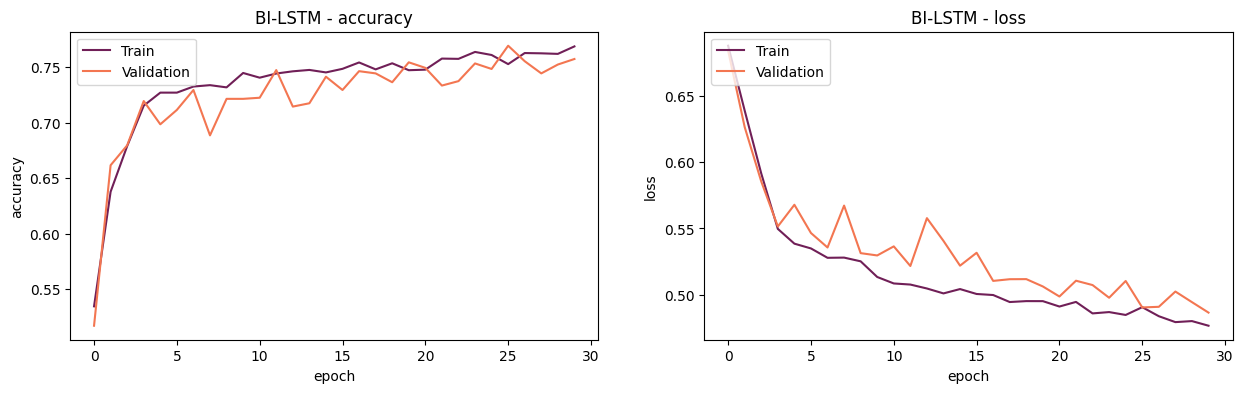

In [ ]:
#plot accuracy and loss
plt.figure(figsize=(15,4))
metrics_plot = ['accuracy', 'loss']
for i,metric in enumerate(metrics_plot):
  plt.subplot(1, 2, i+1)
  experiment = experiments[2]
  plt.plot(experiment.history[metric], color=sns.color_palette('rocket')[1])
  plt.plot(experiment.history[f'val_{metric}'], color=sns.color_palette('rocket')[4])
  plt.title(f'BI-LSTM - {metric}')
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **BI-GRU**

In [ ]:
#BI-GRU
bigru = Sequential(name='BI_GRU')
bigru.add(Bidirectional(GRU(unit, return_sequences=True)))
bigru.add(Dropout(d_rate))
bigru.add(Bidirectional(GRU(unit, return_sequences=True)))
bigru.add(Dropout(d_rate))
bigru.add(Bidirectional(GRU(unit, return_sequences=True)))
bigru.add(Dropout(d_rate))
bigru.add(Bidirectional(GRU(unit)))
bigru.add(Dropout(d_rate))
bigru.add(Dense(1, activation='sigmoid'))
bigru.build(input_shape=X_train_reshaped.shape)
bigru.compile(optimizer=Adam(learning_rate=a_rate), loss='binary_crossentropy', metrics=['accuracy'])
bigru.summary()

Model: "BI_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (4006, 1000, 100)        15900     
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (4006, 1000, 100)         0         
                                                                 
 bidirectional_5 (Bidirectio  (4006, 1000, 100)        45600     
 nal)                                                            
                                                                 
 dropout_13 (Dropout)        (4006, 1000, 100)         0         
                                                                 
 bidirectional_6 (Bidirectio  (4006, 1000, 100)        45600     
 nal)                                                            
                                                            

In [ ]:
#training
checkpoint = ModelCheckpoint('BI_GRU.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
experiments.append(bigru.fit(X_train_reshaped, y_train_reshaped, validation_data=(X_val_reshaped, y_val_reshaped), epochs=deep_epochs, batch_size=deep_size, verbose=1, callbacks=[checkpoint]))
best_bigru = tf.keras.saving.load_model("BI_GRU.h5")

Epoch 1/30
268/268 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5135
Epoch 1: val_accuracy improved from -inf to 0.61178, saving model to BI_GRU.h5
268/268 [==============================] - 70s 211ms/step - loss: 0.6926 - accuracy: 0.5135 - val_loss: 0.6879 - val_accuracy: 0.6118
Epoch 2/30
268/268 [==============================] - ETA: 0s - loss: 0.6664 - accuracy: 0.5999
Epoch 2: val_accuracy improved from 0.61178 to 0.63673, saving model to BI_GRU.h5
268/268 [==============================] - 59s 220ms/step - loss: 0.6664 - accuracy: 0.5999 - val_loss: 0.6460 - val_accuracy: 0.6367
Epoch 3/30
268/268 [==============================] - ETA: 0s - loss: 0.6540 - accuracy: 0.6228
Epoch 3: val_accuracy did not improve from 0.63673
268/268 [==============================] - 54s 202ms/step - loss: 0.6540 - accuracy: 0.6228 - val_loss: 0.6408 - val_accuracy: 0.6267
Epoch 4/30
268/268 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.6166
Ep

In [ ]:
#evaluate
y_bigru_pred = best_bigru.predict(X_val_reshaped)
y_bigru_pred = np.round(y_bigru_pred).flatten()
print(classification_report(y_bigru_pred, y_val_reshaped))

32/32 [==============================] - 5s 88ms/step
              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76       466
         1.0       0.80      0.75      0.78       536

    accuracy                           0.77      1002
   macro avg       0.77      0.77      0.77      1002
weighted avg       0.77      0.77      0.77      1002



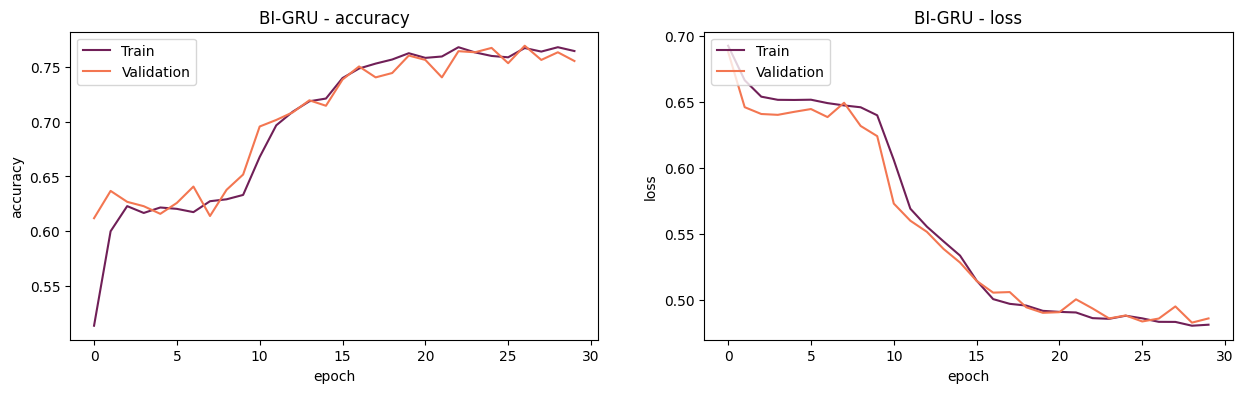

In [ ]:
#plot accuracy and loss
plt.figure(figsize=(15,4))
metrics_plot = ['accuracy', 'loss']
for i,metric in enumerate(metrics_plot):
  plt.subplot(1, 2, i+1)
  experiment = experiments[3]
  plt.plot(experiment.history[metric], color=sns.color_palette('rocket')[1])
  plt.plot(experiment.history[f'val_{metric}'], color=sns.color_palette('rocket')[4])
  plt.title(f'BI-GRU - {metric}')
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **IndoBERT**

In [ ]:
#init IndoBERT Pretrained Model & check cuda
bert = BertClassifier.from_pretrained(indobert, num_labels=2, output_attentions=False, output_hidden_states=False)

device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    bert.to(device)
else:
    device = torch.device("cpu")
print(f'\nDevice available: {device}')

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indober


Device available: cuda


In [ ]:
#function for fine tuning model IndoBERT
def bert_fit(dataloader_train, dataloader_val, epochs):
  history = []
  monitor_acc = 0
  for epoch in range(0, epochs):
    #initial stats
    total_loss_train, total_acc_train = 0, 0
    total_loss_val, total_acc_val = 0, 0
    y_pred_train, y_actual_train = [], []
    y_pred_val, y_actual_val = [], []
    print(f'Epoch {epoch+1}/{epochs}')

    format = '{n_fmt}/{total_fmt} [{bar}] {rate_fmt}{postfix}'

    #train with progress bar
    with tqdm(total=len(dataloader_train), bar_format=format) as progress:
      bert.train() #start training
      for batch_train in dataloader_train:
        bert.zero_grad()
        inputs_train = {
          'input_ids':      batch_train[0].to(device),
          'attention_mask': batch_train[1].to(device),
          'labels':         batch_train[2].to(device),
        }
        outputs_train = bert(**inputs_train)
        loss_train, logits_train = outputs_train[0], outputs_train[1]
        logits_train = logits_train.detach().cpu().tolist()
        label_train = inputs_train['labels'].cpu().tolist()
        total_loss_train += loss_train.item()

        y_pred_train.extend(logits_train)
        y_actual_train.extend(label_train)

        torch.nn.utils.clip_grad_norm_(bert.parameters(), 1.0)
        loss_train.backward()
        optimizer.step()
        scheduler.step()
        progress.update(1)

      bert.eval() #start validation
      for batch_val in dataloader_val:
        inputs_val = {
            'input_ids':      batch_val[0].to(device),
            'attention_mask': batch_val[1].to(device),
            'labels':         batch_val[2].to(device),
        }
        with torch.no_grad():
          outputs_val = bert(**inputs_val)
        loss_val, logits_val = outputs_val[0], outputs_val[1]
        logits_val = logits_val.detach().cpu().numpy()
        label_val = inputs_val['labels'].cpu().tolist()
        total_loss_val += loss_val.item()

        y_pred_val.extend(logits_val)
        y_actual_val.extend(label_val)

      #recalculte loss and acc
      total_loss_train = total_loss_train/len(dataloader_train)
      total_acc_train  = accuracy_score(np.argmax(y_pred_train, axis=1).tolist(), y_actual_train)
      total_loss_val   = total_loss_val/len(dataloader_val)
      total_acc_val    = accuracy_score(np.argmax(y_pred_val, axis=1).tolist(), y_actual_val)

      #keep history each epoch
      stats = {
          'epoch':        epoch+1,
          'loss':         total_loss_train/len(dataloader_train),
          'accuracy':     accuracy_score(np.argmax(y_pred_train, axis=1).tolist(), y_actual_train),
          'val_loss':     total_loss_val/len(dataloader_val),
          'val_accuracy': accuracy_score(np.argmax(y_pred_val, axis=1).tolist(), y_actual_val)
      }
      history.append(stats)

      #monitoring accuracy
      improvement = 'Not Improved'
      if total_acc_val > monitor_acc:
        monitor_acc = total_acc_val
        improvement = 'Improved'

      #save last model
      torch.save(bert.state_dict(), 'IndoBERT.model')

      #display progress
      stats.pop('epoch')
      stats['monitoring'] = improvement
      progress.set_postfix(stats, refresh=False)
      progress.set_description(improvement)
      clean_memory()
  return history

#function for display layer of IndoBERT
def bert_summary(params):
  summary = []
  for p in params:
    summary.append([p[0], str(tuple(p[1].size()))])
  summary.insert(4, ['='*55, '='*13])
  summary.insert(5, ['Transformer Layer', 'Shape'])
  summary.insert(6, ['='*55, '='*13])
  summary.insert(0, ['='*55, '='*13])
  summary.insert(0, ['Embedding Layer', 'shape'])
  summary.insert(0, ['='*55, '='*13])
  summary.insert(-4, ['='*55, '='*13])
  summary.insert(-4, ['Output Layer', 'shape'])
  summary.insert(-4, ['='*55, '='*13])
  print(f'Model: BERT')
  print(f'Total Parameters: {len(list(params))}')
  print(tabulate(summary, tablefmt='plain'))

In [ ]:
bert_summary(bert.named_parameters())

Model: BERT
Total Parameters: 0
=======================================================  =============
Embedding Layer                                          shape
=======================================================  =============
bert.embeddings.word_embeddings.weight                   (31923, 768)
bert.embeddings.position_embeddings.weight               (512, 768)
bert.embeddings.token_type_embeddings.weight             (2, 768)
bert.embeddings.LayerNorm.weight                         (768,)
=======================================================  =============
Transformer Layer                                        Shape
=======================================================  =============
bert.embeddings.LayerNorm.bias                           (768,)
bert.encoder.layer.0.attention.self.query.weight         (768, 768)
bert.encoder.layer.0.attention.self.query.bias           (768,)
bert.encoder.layer.0.attention.self.key.weight           (768, 768)
bert.encoder.layer.0.atten

In [ ]:
#Create the Data Loaders & Optimizer & Scheduler
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=bert_size)
dataloader_val = DataLoader(dataset_val, sampler=RandomSampler(dataset_val), batch_size=bert_size)
optimizer = AdamW(bert.parameters(), lr=a_rate)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*bert_epochs)

#Retraining model bert (fine tuning)
experiments.append(bert_fit(dataloader_train, dataloader_val, bert_epochs))

Epoch 1/10


268/268 [██████████]  1.75it/s, loss=0.0024, accuracy=0.648, val_loss=0.00785, val_accuracy=0.753, monitoring=Improved


Epoch 2/10


268/268 [██████████]  1.67it/s, loss=0.00189, accuracy=0.77, val_loss=0.00833, val_accuracy=0.722, monitoring=Not Improved


Epoch 3/10


268/268 [██████████]  1.71it/s, loss=0.00145, accuracy=0.838, val_loss=0.00955, val_accuracy=0.728, monitoring=Not Improved


Epoch 4/10


268/268 [██████████]  1.72it/s, loss=0.00113, accuracy=0.887, val_loss=0.0106, val_accuracy=0.729, monitoring=Not Improved


Epoch 5/10


268/268 [██████████]  1.75it/s, loss=0.000872, accuracy=0.919, val_loss=0.0104, val_accuracy=0.713, monitoring=Not Improved


Epoch 6/10


268/268 [██████████]  1.71it/s, loss=0.000556, accuracy=0.956, val_loss=0.0135, val_accuracy=0.716, monitoring=Not Improved


Epoch 7/10


268/268 [██████████]  1.71it/s, loss=0.000381, accuracy=0.971, val_loss=0.0165, val_accuracy=0.716, monitoring=Not Improved


Epoch 8/10


268/268 [██████████]  1.71it/s, loss=0.000325, accuracy=0.976, val_loss=0.017, val_accuracy=0.716, monitoring=Not Improved


Epoch 9/10


268/268 [██████████]  1.72it/s, loss=0.00029, accuracy=0.984, val_loss=0.0174, val_accuracy=0.704, monitoring=Not Improved


Epoch 10/10


268/268 [██████████]  1.71it/s, loss=0.000223, accuracy=0.987, val_loss=0.0169, val_accuracy=0.709, monitoring=Not Improved


In [ ]:
state_dict = torch.load("IndoBERT.model" )
bert_eval = BertClassifier.from_pretrained(indobert, num_labels=2, output_attentions=False, output_hidden_states=False)
bert_eval.load_state_dict(state_dict)
bert_eval.to(device)
y_pred_val, y_actual_val = [], []
bert_eval.eval()
for batch_val in dataloader_val:
  inputs_val = {
      'input_ids':      batch_val[0].to(device),
      'attention_mask': batch_val[1].to(device),
      'labels':         batch_val[2].to(device),
  }
  with torch.no_grad():
    outputs_val = bert_eval(**inputs_val)
  loss_val, logits_val = outputs_val[0], outputs_val[1]
  logits_val = logits_val.detach().cpu().numpy()
  label_val = inputs_val['labels'].cpu().tolist()

  y_pred_val.extend(logits_val)
  y_actual_val.extend(label_val)

print(classification_report(np.argmax(y_pred_val, axis=1).tolist(), y_actual_val))

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indober

              precision    recall  f1-score   support

           0       0.67      0.73      0.70       463
           1       0.75      0.69      0.72       539

    accuracy                           0.71      1002
   macro avg       0.71      0.71      0.71      1002
weighted avg       0.71      0.71      0.71      1002



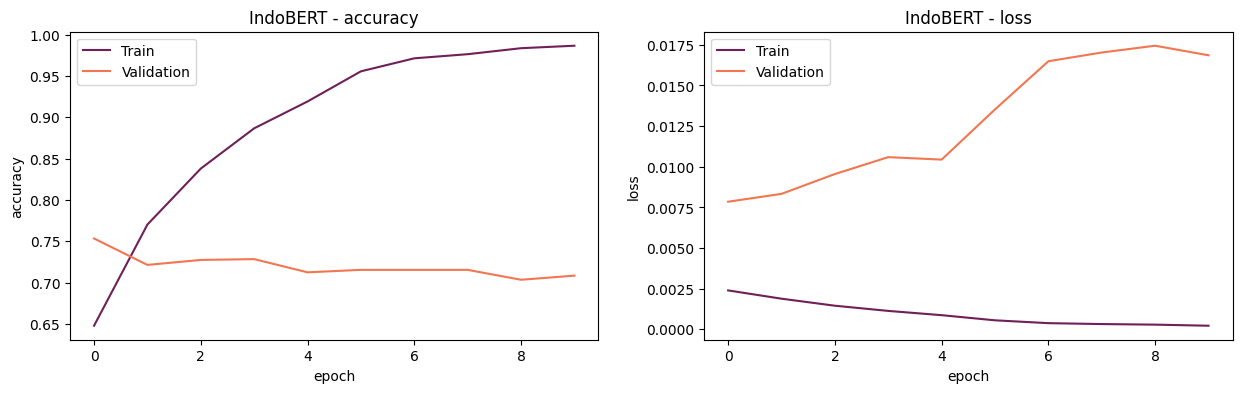

In [ ]:
#plot accuracy and loss
plt.figure(figsize=(15,4))
metrics_plot = ['accuracy', 'loss']
for i,metric in enumerate(metrics_plot):
  plt.subplot(1, 2, i+1)
  experiment = experiments[4]
  plt.plot([item[metric] for item in experiment], color=sns.color_palette('rocket')[1])
  plt.plot([item[f'val_{metric}'] for item in experiment], color=sns.color_palette('rocket')[4])
  plt.title(f'IndoBERT - {metric}')
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#show time execution
print(round((time.time() - start_time)/60, 3), 'min')

115.438 min
